# Question 1

### Exercise 1.(b)

In [35]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

# Load the pretrained model from pytorch
alexnet = models.alexnet(weights= models.AlexNet_Weights.DEFAULT)
alexnet.eval()





AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

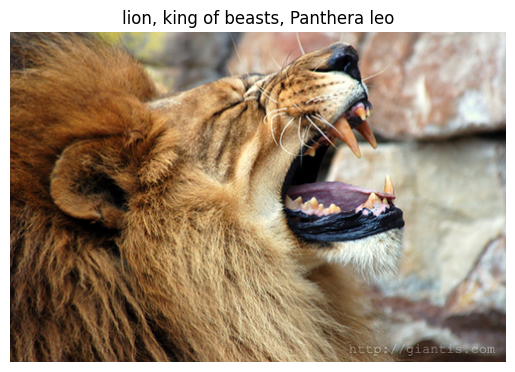

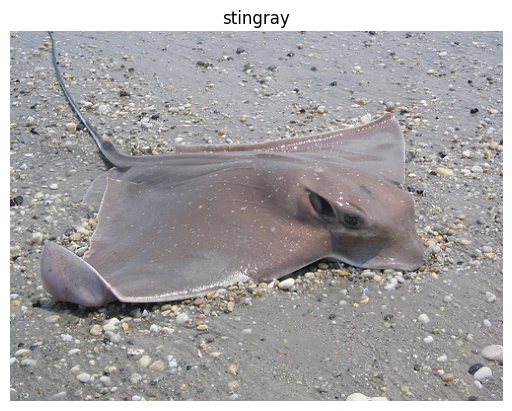

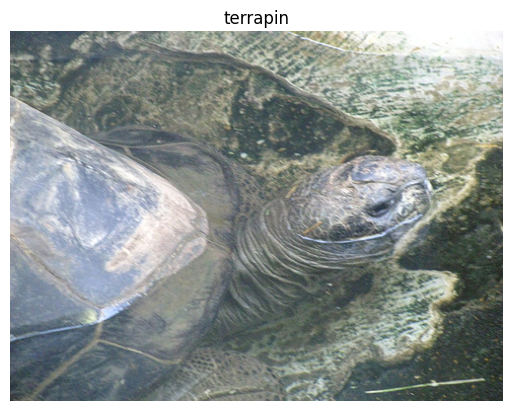

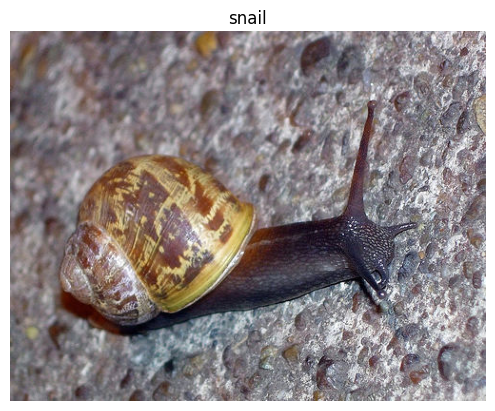

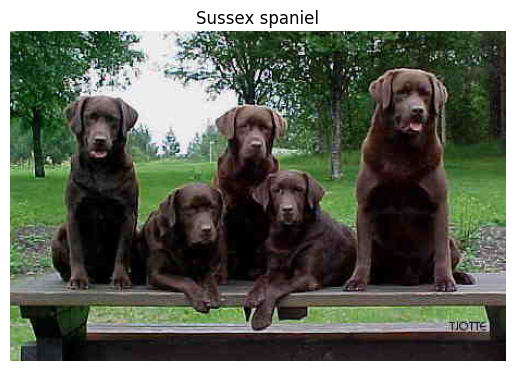

In [56]:
import requests
import ast
from PIL import Image
from io import BytesIO

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

alexnet.to(device)


# Load labels
class_labels_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
response = requests.get(class_labels_url)
class_label_dict = ast.literal_eval(response.text)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# prediction function , get the top predicted class
def predict(imgurl, model):
    response = requests.get(imgurl)
    img = Image.open(BytesIO(response.content))
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    model.eval()
    with torch.no_grad():
        out = model(batch_t.to(device))
    _, top_pred = torch.topk(out, 1)
    top_pred = top_pred.item()
    label = class_label_dict[top_pred]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
    plt.show()

# Load the image
list_of_images = ["https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02129165_19260_lion.jpg", 
                  "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n01495701_1216_ray.jpg",
                    "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n01662784_3789_turtle.jpg",
                    "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n01944390_7816_snail.jpg",
                    "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02084071_19639_dog.jpg"


                  ]

for img in list_of_images:
    predict(img, alexnet)


### Exercise 1.(c)

Original image: 


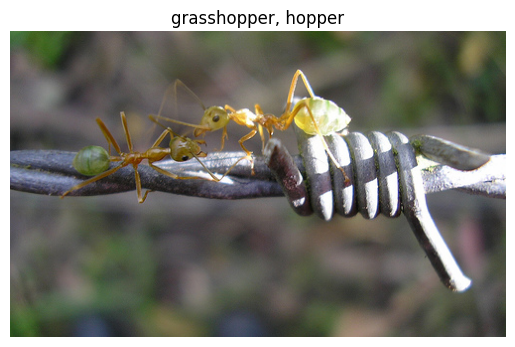

Target class reached. Iteration: 8, Loss: 7.674493312835693
Adversarial example for target class Kerry blue terrier
Target class reached. Iteration: 6, Loss: 7.784191131591797
Adversarial example for target class toy poodle
Target class reached. Iteration: 4, Loss: 6.469971179962158
Adversarial example for target class water jug


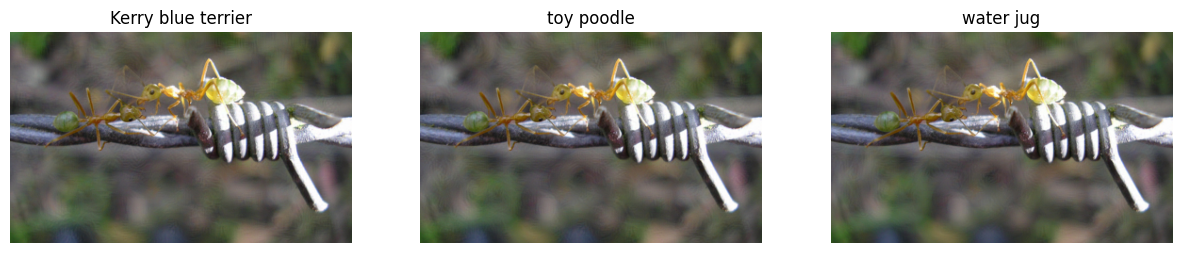

Original image: 


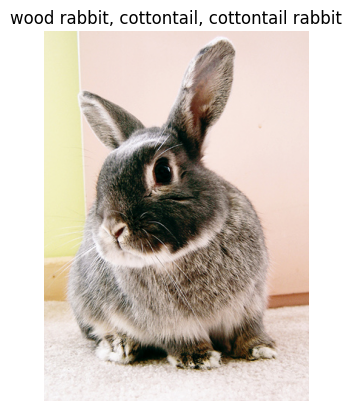

Target class reached. Iteration: 4, Loss: 5.4907050132751465
Adversarial example for target class sloth bear, Melursus ursinus, Ursus ursinus
Target class reached. Iteration: 7, Loss: 6.2488932609558105
Adversarial example for target class iPod
Target class reached. Iteration: 7, Loss: 7.710564136505127
Adversarial example for target class African elephant, Loxodonta africana


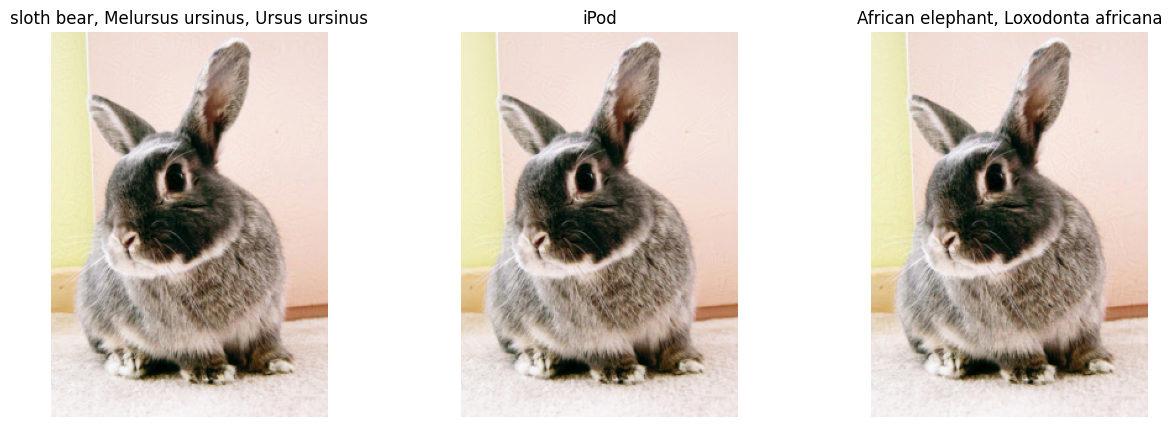

In [80]:
import random
import torch.optim as optim


def preprocess_image(img):
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0).to(device)
    return batch_t

def deprocess_image(img):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(img)
    img = img.clamp(0, 1)
    img = transforms.ToPILImage()(img.cpu().squeeze(0))
    return img
    

# Create adversarial examples
def create_adversarial_example(img, target_class, model, alpha, learning_rate, max_iter = 1000):
    img_var = img.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([img_var], lr=learning_rate)
    target_class_var = torch.tensor([target_class], dtype=torch.long).to(device)
    for i in range(max_iter):
        optimizer.zero_grad()
        out = model(img_var)
        loss = alpha * torch.norm(img_var-img , p =1)+ torch.nn.CrossEntropyLoss()(out, target_class_var)
        loss.backward()
        optimizer.step()
        _, top_pred = torch.topk(out, 1)
        if top_pred.item() == target_class:
            print("Target class reached. Iteration: {}, Loss: {}".format(i, loss.item()))
            break
    return img_var.detach()

random_sample_image = ["https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02219486_21998_ant.jpg",
                       "https://raw.githubusercontent.com/ajschumacher/imagen/master/imagen/n02324045_13467_rabbit.jpg"]

alpha = 0.001
learning_rate = 0.01
max_iter = 100

for img_url in random_sample_image:
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    img_t= preprocess_image(img)
    with torch.no_grad():
        true_class = torch.argmax(alexnet(img_t)).item()
    target_classes = random.sample([i for i in range(1000) if i != true_class], 3)
    print ("Original image: ")
    predict(img_url, alexnet)
    adversarial_list = []
    for target_class in target_classes:
        adversial_example = create_adversarial_example(img_t, target_class, alexnet, alpha, learning_rate, max_iter)
        adversial_example_img = deprocess_image(adversial_example)
        adversarial_list.append(adversial_example_img)
        print (f"Adversarial example for target class {class_label_dict[target_class]}")
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, adv_example_img in enumerate(adversarial_list):
        axs[i].imshow(adv_example_img)
        axs[i].set_title(class_label_dict[torch.argmax(alexnet(preprocess_image(adv_example_img))).item()])
        axs[i].axis('off')
    plt.show()




# Question 3
### Exercise 3.(c)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Using nn.Linear
class PositionwiseFeedForwardLinear(nn.Module):
    def __init__(self, d_model):
        super(PositionwiseFeedForwardLinear, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model)

    def forward(self, x):
        return (F.relu(self.w_1(x)))

#Using nn.Conv1d
class PositionwiseFeedForwardConv(nn.Module):
    def __init__(self, d_model):
        super(PositionwiseFeedForwardConv, self).__init__()
        self.w_1 = nn.Conv1d(d_model, d_model, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.w_1(x))
        return x.permute(0, 2, 1)
    
B,T,D = 16,32,64
Z = torch.randn(B,T,D)

linear_ffn = PositionwiseFeedForwardLinear(D)
conv_ffn = PositionwiseFeedForwardConv(D)

with torch.no_grad():
    linear_ffn.w_1.weight.copy_(conv_ffn.w_1.weight.squeeze())
    linear_ffn.w_1.bias.copy_(conv_ffn.w_1.bias)

linear_output = linear_ffn(Z)
conv1d_output = conv_ffn(Z)



assert torch.allclose(linear_output, conv1d_output, atol=1e-5), "Outputs do not match"

print("Success!")
   




Success!
